#### https://slundberg.github.io/shap/notebooks/League%20of%20Legends%20Win%20Prediction%20with%20XGBoost.html

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as pl

shap.initjs()

In [3]:
# read in the data
matches = pd.read_csv("matches.csv")
participants = pd.read_csv("participants.csv")
stats1 = pd.read_csv("stats1.csv", low_memory=False)
stats2 = pd.read_csv("stats2.csv", low_memory=False)
stats = pd.concat([stats1,stats2])

# merge into a single DataFrame
a = pd.merge(participants, matches, left_on="matchid", right_on="id")
allstats_orig = pd.merge(a, stats, left_on="matchid", right_on="id")
allstats = allstats_orig.copy()

# drop games that lasted less than 10 minutes
allstats = allstats.loc[allstats["duration"] >= 10*60,:]

# Convert string-based categories to numeric values
cat_cols = ["role", "position", "version", "platformid"]
for c in cat_cols:
    allstats[c] = allstats[c].astype('category')
    allstats[c] = allstats[c].cat.codes
allstats["wardsbought"] = allstats["wardsbought"].astype(np.int32)

X = allstats.drop(["win"], axis=1)
y = allstats["win"]

# convert all features we want to consider as rates
rate_features = [
    "kills", "deaths", "assists", "killingsprees", "doublekills",
    "triplekills", "quadrakills", "pentakills", "legendarykills",
    "totdmgdealt", "magicdmgdealt", "physicaldmgdealt", "truedmgdealt",
    "totdmgtochamp", "magicdmgtochamp", "physdmgtochamp", "truedmgtochamp",
    "totheal", "totunitshealed", "dmgtoobj", "timecc", "totdmgtaken",
    "magicdmgtaken" , "physdmgtaken", "truedmgtaken", "goldearned", "goldspent",
    "totminionskilled", "neutralminionskilled", "ownjunglekills",
    "enemyjunglekills", "totcctimedealt", "pinksbought", "wardsbought",
    "wardsplaced", "wardskilled"
]
for feature_name in rate_features:
    X[feature_name] /= X["duration"] / 60 # per minute rate

# convert to fraction of game
X["longesttimespentliving"] /= X["duration"]

# define friendly names for the features
full_names = {
    "kills": "Kills per min.",
    "deaths": "Deaths per min.",
    "assists": "Assists per min.",
    "killingsprees": "Killing sprees per min.",
    "longesttimespentliving": "Longest time living as % of game",
    "doublekills": "Double kills per min.",
    "triplekills": "Triple kills per min.",
    "quadrakills": "Quadra kills per min.",
    "pentakills": "Penta kills per min.",
    "legendarykills": "Legendary kills per min.",
    "totdmgdealt": "Total damage dealt per min.",
    "magicdmgdealt": "Magic damage dealt per min.",
    "physicaldmgdealt": "Physical damage dealt per min.",
    "truedmgdealt": "True damage dealt per min.",
    "totdmgtochamp": "Total damage to champions per min.",
    "magicdmgtochamp": "Magic damage to champions per min.",
    "physdmgtochamp": "Physical damage to champions per min.",
    "truedmgtochamp": "True damage to champions per min.",
    "totheal": "Total healing per min.",
    "totunitshealed": "Total units healed per min.",
    "dmgtoobj": "Damage to objects per min.",
    "timecc": "Time spent with crown control per min.",
    "totdmgtaken": "Total damage taken per min.",
    "magicdmgtaken": "Magic damage taken per min.",
    "physdmgtaken": "Physical damage taken per min.",
    "truedmgtaken": "True damage taken per min.",
    "goldearned": "Gold earned per min.",
    "goldspent": "Gold spent per min.",
    "totminionskilled": "Total minions killed per min.",
    "neutralminionskilled": "Neutral minions killed per min.",
    "ownjunglekills": "Own jungle kills per min.",
    "enemyjunglekills": "Enemy jungle kills per min.",
    "totcctimedealt": "Total crown control time dealt per min.",
    "pinksbought": "Pink wards bought per min.",
    "wardsbought": "Wards bought per min.",
    "wardsplaced": "Wards placed per min.",
    "turretkills": "# of turret kills",
    "inhibkills": "# of inhibitor kills",
    "dmgtoturrets": "Damage to turrets"
}
feature_names = [full_names.get(n, n) for n in X.columns]
X.columns = feature_names

# create train/validation split
Xt, Xv, yt, yv = train_test_split(X,y, test_size=0.2, random_state=10)
dt = xgb.DMatrix(Xt, label=yt.values)
dv = xgb.DMatrix(Xv, label=yv.values)

In [4]:
params = {
    "eta": 0.5,
    "max_depth": 4,
    "objective": "binary:logistic",
    "silent": 1,
    "base_score": np.mean(yt),
    "eval_metric": "logloss"
}
model = xgb.train(params, dt, 300, [(dt, "train"),(dv, "valid")], early_stopping_rounds=5, verbose_eval=25)

[00:03:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:0.54126	valid-logloss:0.54136
[25]	train-logloss:0.28626	valid-logloss:0.28660
[50]	train-logloss:0.25209	valid-logloss:0.25362
[75]	train-logloss:0.23394	valid-logloss:0.23624
[100]	train-logloss:0.22131	valid-logloss:0.22434
[125]	train-logloss:0.21189	valid-logloss:0.21589
[150]	train-logloss:0.20330	valid-logloss:0.20811
[175]	train-logloss:0.19674	valid-logloss:0.20190
[200]	train-logloss:0.19017	valid-logloss:0.19572
[225]	train-logloss:0.18355	valid-logloss:0.18960
[250]	train-logloss:0.17862	valid-logloss:0.18499
[275]	train-logloss:0.17313	valid-loglos

In [5]:
# compute the SHAP values for every prediction in the validation dataset
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xv)

In [6]:
shap.force_plot(explainer.expected_value, shap_values[0,:], Xv.iloc[0,:])

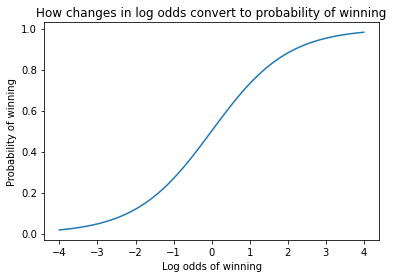

In [7]:
xs = np.linspace(-4,4,100)
pl.xlabel("Log odds of winning")
pl.ylabel("Probability of winning")
pl.title("How changes in log odds convert to probability of winning")
pl.plot(xs, 1/(1+np.exp(-xs)))
pl.show()

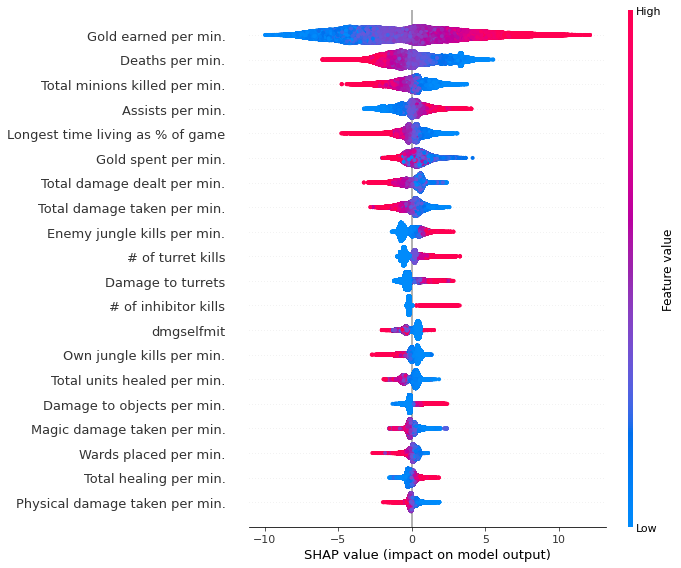

In [8]:
shap.summary_plot(shap_values, Xv)

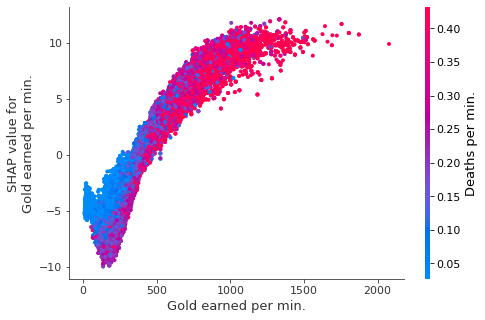

In [9]:
shap.dependence_plot("Gold earned per min.", shap_values, Xv, interaction_index="Deaths per min.")

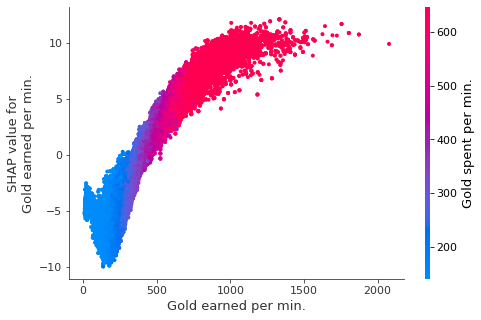

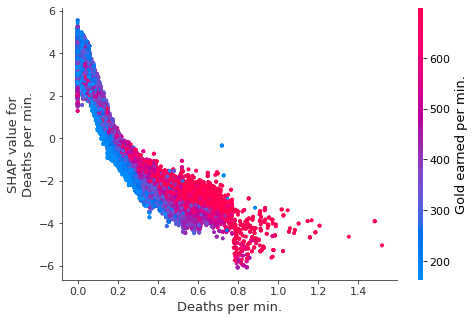

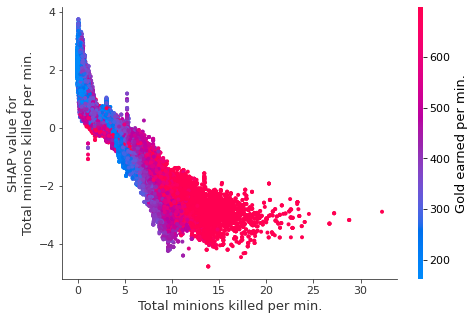

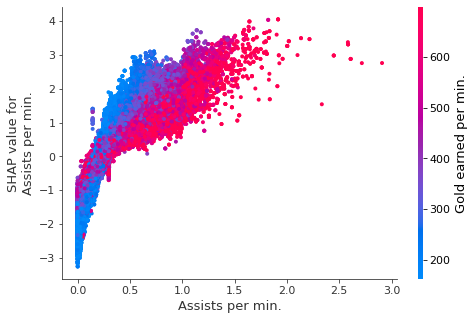

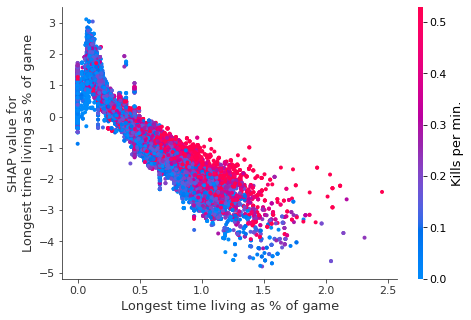

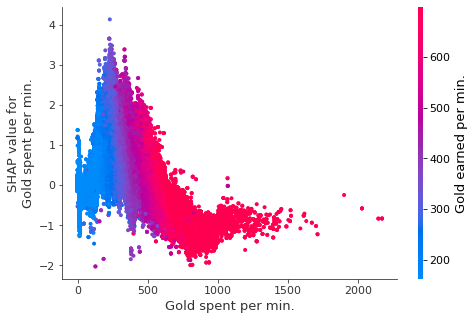

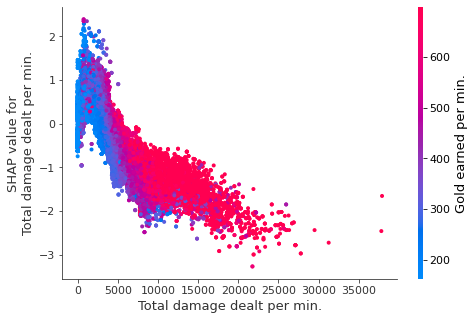

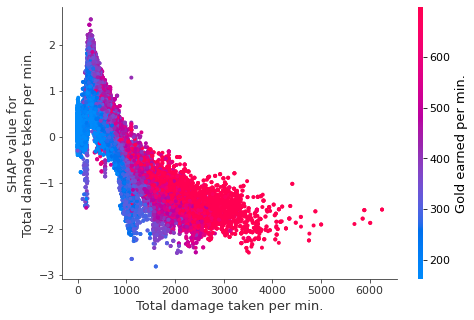

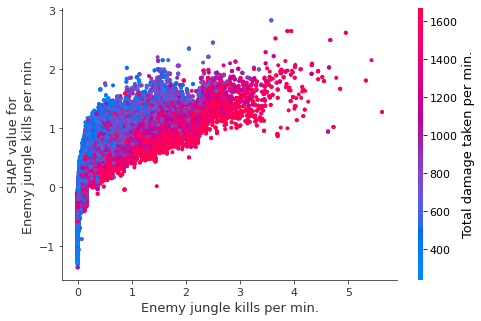

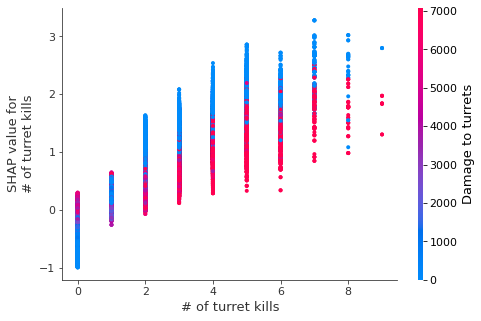

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


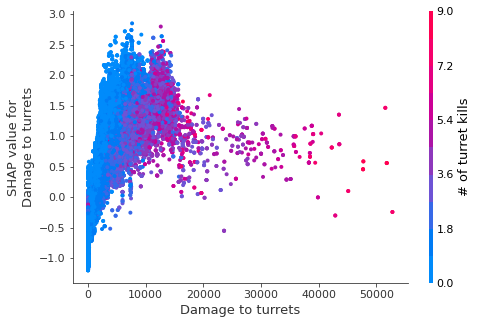

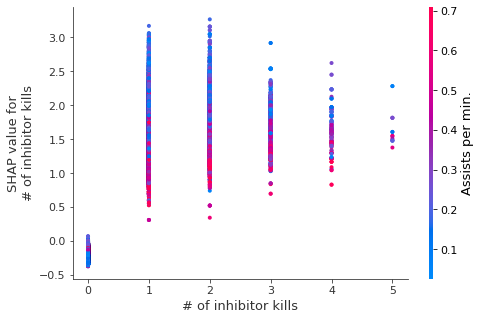

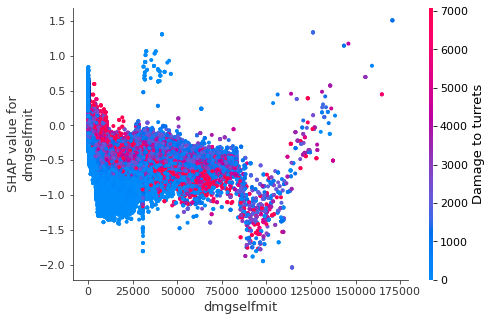

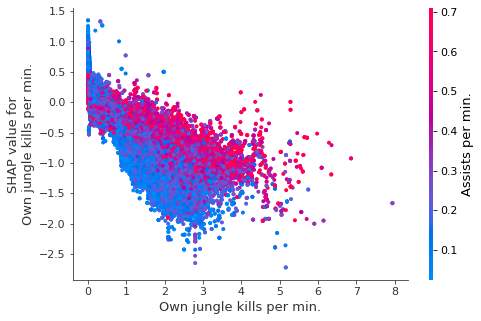

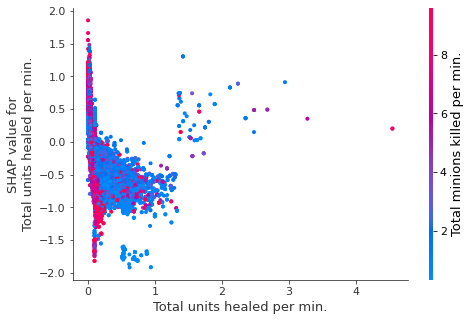

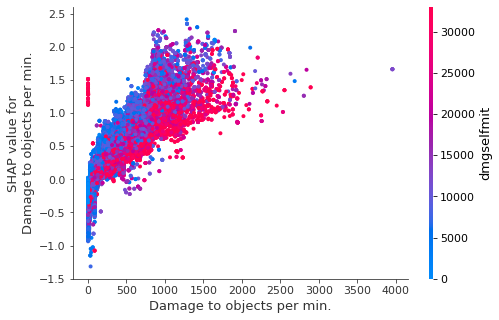

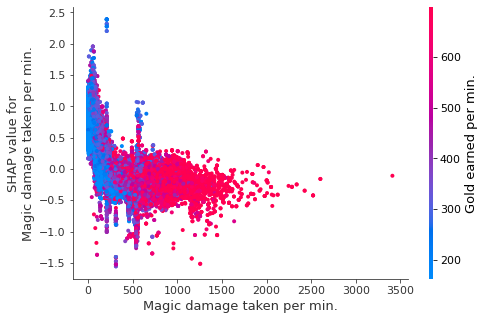

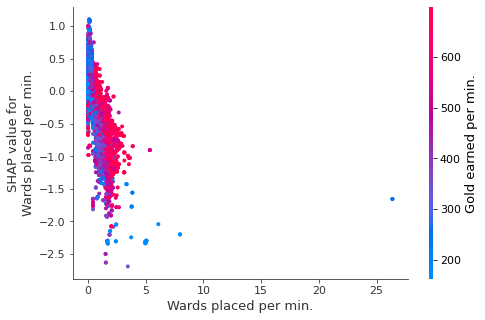

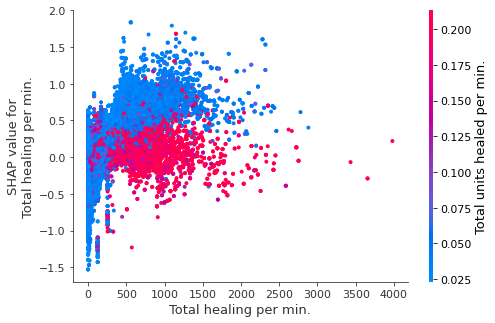

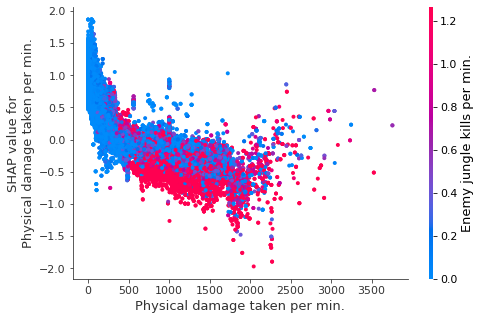

In [10]:
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# make SHAP plots of the three most important features
for i in range(20):
    shap.dependence_plot(top_inds[i], shap_values, Xv)